In [1]:
# Fix randomness
random_state=42
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
%matplotlib inline
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict 
from sklearn.metrics import roc_curve, roc_auc_score #AUC score
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [2]:
#for making a roc_curve visualization
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(12,10))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [3]:
#profit-threshold 
L_gd = 0.25
r = 0.05
C_FP = r
C_FN = L_gd
def profit_threshold2(fpr,tpr,a,y_true):
    temp = pd.DataFrame({'fpr': fpr, 'tpr': tpr,"a":a})
    temp["profit"] = (y_true==0).sum() * (1 - temp["fpr"]) * (C_FP) + (y_true==1).sum() * (1 - temp["tpr"]) * (-L_gd)
    return temp, temp.loc[temp["profit"].idxmax()-2:temp["profit"].idxmax()+2],temp.loc[temp["profit"].idxmax(),"a"]

# Import Data

In [4]:
#Split training and validation sets 
whole_data = pd.read_csv("../input/cs-training.csv")
X = whole_data.drop("SeriousDlqin2yrs", axis=1).copy()
y = whole_data.SeriousDlqin2yrs

In [5]:
whole_data.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [6]:
print("Original dataset shape {}".format(Counter(y)))

Original dataset shape Counter({0: 139974, 1: 10026})


In [7]:
#training set:valuation set=3:1
X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=42)
print("Original dataset shape {}".format(Counter(y_train)))
print("Original dataset shape {}".format(Counter(y_val)))

Original dataset shape Counter({0: 104949, 1: 7551})
Original dataset shape Counter({0: 35025, 1: 2475})


In [8]:
training_set= pd.concat([X_train, y_train], axis=1)
validation_set = pd.concat([X_val, y_val], axis=1)

# Check basic information of variables

In [9]:
training_set.info()
training_set.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 112500 entries, 92988 to 121958
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            112500 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  112500 non-null  float64
 2   age                                   112500 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  112500 non-null  int64  
 4   DebtRatio                             112500 non-null  float64
 5   MonthlyIncome                         90223 non-null   float64
 6   NumberOfOpenCreditLinesAndLoans       112500 non-null  int64  
 7   NumberOfTimes90DaysLate               112500 non-null  int64  
 8   NumberRealEstateLoansOrLines          112500 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  112500 non-null  int64  
 10  NumberOfDependents                    109562 non-null  float64
 11  S

,Unnamed: 0,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
count,112500.000000,112500.000000,112500.000000,112500.000000,112500.000000,9.022300e+04,112500.000000,112500.000000,112500.000000,112500.000000,109562.000000,112500.000000
mean,74961.876676,5.695359,52.288302,0.424062,351.962978,6.682989e+03,8.461564,0.267209,1.018924,0.241316,0.758475,0.067120
std,43333.928533,251.578602,14.766866,4.206304,1978.923775,1.561086e+04,5.145291,4.182446,1.130766,4.168206,1.117452,0.250231
min,2.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37449.750000,0.030106,41.000000,0.000000,0.175877,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,74889.500000,0.155192,52.000000,0.000000,0.367473,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,112530.250000,0.559117,63.000000,0.000000,0.871193,8.250000e+03,11.000000,0.000000,2.000000,0.000000,1.000000,0.000000
max,150000.000000,50708.000000,109.000000,98.000000,326442.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,13.000000,1.000000


In [10]:
validation_set.info()
validation_set.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 37500 entries, 59770 to 40589
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            37500 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  37500 non-null  float64
 2   age                                   37500 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  37500 non-null  int64  
 4   DebtRatio                             37500 non-null  float64
 5   MonthlyIncome                         30046 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       37500 non-null  int64  
 7   NumberOfTimes90DaysLate               37500 non-null  int64  
 8   NumberRealEstateLoansOrLines          37500 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  37500 non-null  int64  
 10  NumberOfDependents                    36514 non-null  float64
 11  SeriousDlqin2yrs

,Unnamed: 0,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
count,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,30046.000000,37500.000000,37500.000000,37500.000000,37500.000000,36514.000000,37500.000000
mean,75116.369973,7.107677,52.315920,0.411947,356.131369,6631.882680,8.426347,0.262267,1.016187,0.237600,0.753464,0.066000
std,43204.095447,244.204260,14.787033,4.151991,2205.109916,9822.269844,5.147908,4.129680,1.126794,4.115907,1.107963,0.248285
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37682.250000,0.029303,41.000000,0.000000,0.172598,3400.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,75283.000000,0.150867,52.000000,0.000000,0.363773,5414.000000,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,112404.250000,0.558622,63.000000,0.000000,0.857691,8218.250000,11.000000,0.000000,2.000000,0.000000,1.000000,0.000000
max,149994.000000,22000.000000,102.000000,98.000000,329664.000000,835040.000000,57.000000,98.000000,29.000000,98.000000,20.000000,1.000000


# Data Preprocessing

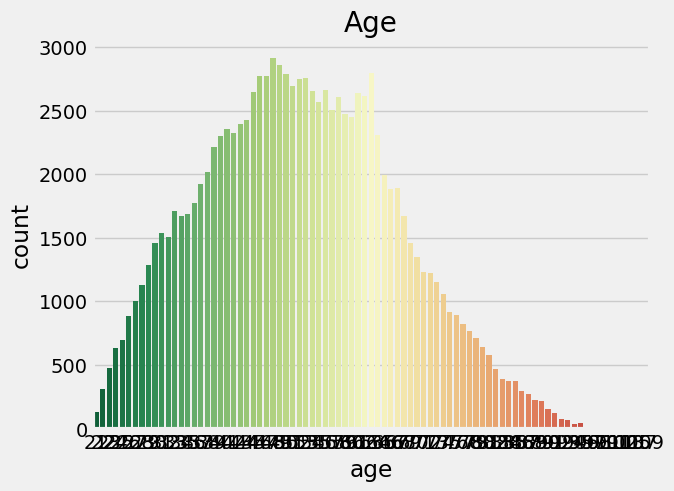

In [11]:
# change unreasonable value for age
training_set.loc[training_set["age"] <18, "age"] = training_set.age.median()#less than legal age
sns.countplot(x = "age", data=training_set, palette='RdYlGn_r') 
plt.title('Age')
plt.savefig('age_distribution.png')

<Axes: >

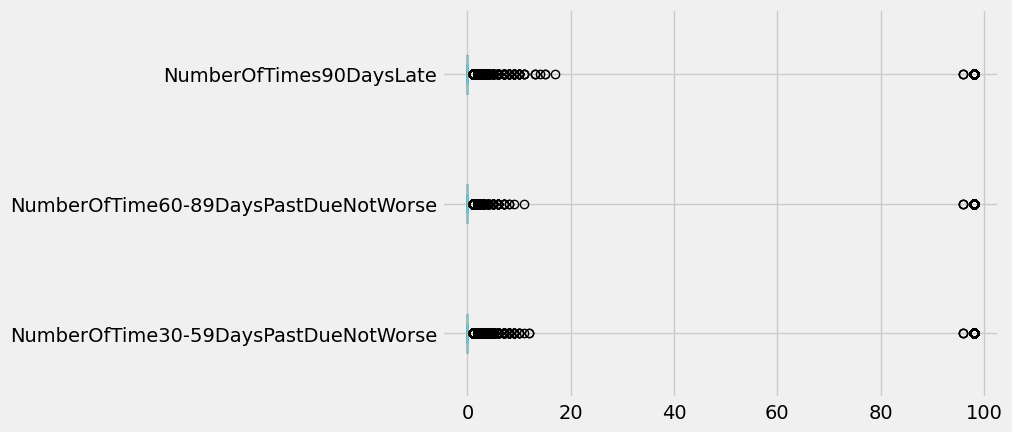

In [12]:
#change unreasonable value for NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate
columns=['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTimes90DaysLate'] 
training_set[columns].plot.box(vert = False)

In [13]:
training_set.loc[training_set['NumberOfTime30-59DaysPastDueNotWorse'] > 20, 'NumberOfTime30-59DaysPastDueNotWorse']=training_set["NumberOfTime30-59DaysPastDueNotWorse"].median()
training_set.loc[training_set['NumberOfTime60-89DaysPastDueNotWorse'] > 20, 'NumberOfTime60-89DaysPastDueNotWorse']=training_set["NumberOfTime60-89DaysPastDueNotWorse"].median()
training_set.loc[training_set['NumberOfTimes90DaysLate'] > 20, 'NumberOfTimes90DaysLate']=training_set["NumberOfTimes90DaysLate"].median()

<Axes: >

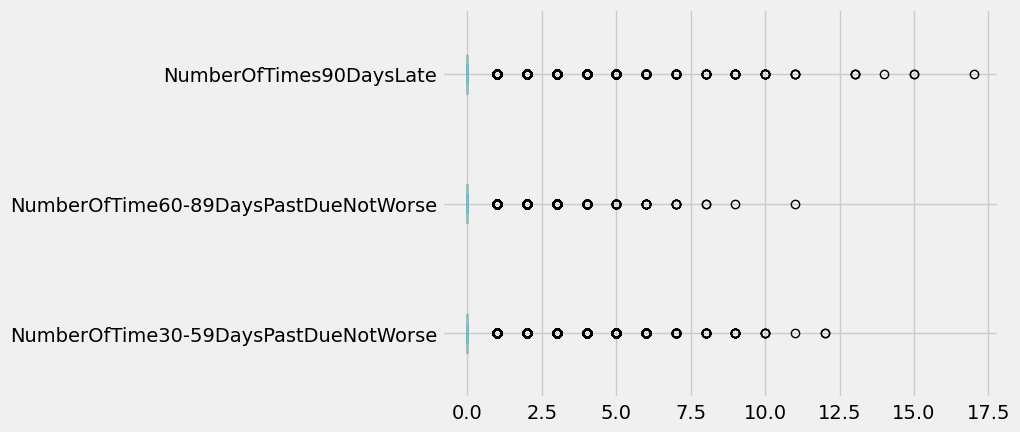

In [14]:
training_set[columns].plot.box(vert = False)

In [15]:
#impute missing values for the MonthlyIncome feature
age_working_impute = training_set.loc[(training_set["age"] >= 18) & (training_set["age"] < 60)].MonthlyIncome.median()
age_senior_impute = training_set.loc[(training_set["age"] >= 60)].MonthlyIncome.median()
#change the monthlyincome data type to int64 then fill those null values with 99999 and impute with the corresponding age's monthlyincome median.
training_set["MonthlyIncome"] = np.absolute(training_set["MonthlyIncome"])
training_set["MonthlyIncome"] = training_set["MonthlyIncome"].fillna(99999)
training_set["MonthlyIncome"] = training_set["MonthlyIncome"].astype('int64')
training_set.loc[((training_set["age"] >= 18) & (training_set["age"] < 60)) & (training_set["MonthlyIncome"] == 99999),\
               "MonthlyIncome"] = age_working_impute
training_set.loc[(training_set["age"] >= 60) & (training_set["MonthlyIncome"] == 99999), "MonthlyIncome"] = age_senior_impute
training_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112500 entries, 92988 to 121958
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            112500 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  112500 non-null  float64
 2   age                                   112500 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  112500 non-null  int64  
 4   DebtRatio                             112500 non-null  float64
 5   MonthlyIncome                         112500 non-null  int64  
 6   NumberOfOpenCreditLinesAndLoans       112500 non-null  int64  
 7   NumberOfTimes90DaysLate               112500 non-null  int64  
 8   NumberRealEstateLoansOrLines          112500 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  112500 non-null  int64  
 10  NumberOfDependents                    109562 non-null  float64
 11  S

In [16]:
#NumberOfDependents feature
training_set["NumberOfDependents"] = np.absolute(training_set["NumberOfDependents"])
training_set.NumberOfDependents.value_counts()

NumberOfDependents
0.0     65237
1.0     19632
2.0     14608
3.0      7133
4.0      2198
5.0       569
6.0       122
7.0        36
8.0        19
10.0        4
9.0         3
13.0        1
Name: count, dtype: int64

In [17]:
#inpute NumberOfDependents by mode
training_set["NumberOfDependents"] = training_set["NumberOfDependents"].fillna(0)
training_set["NumberOfDependents"] = training_set["NumberOfDependents"].astype('int64')
training_set.NumberOfDependents.value_counts()

NumberOfDependents
0     68175
1     19632
2     14608
3      7133
4      2198
5       569
6       122
7        36
8        19
10        4
9         3
13        1
Name: count, dtype: int64

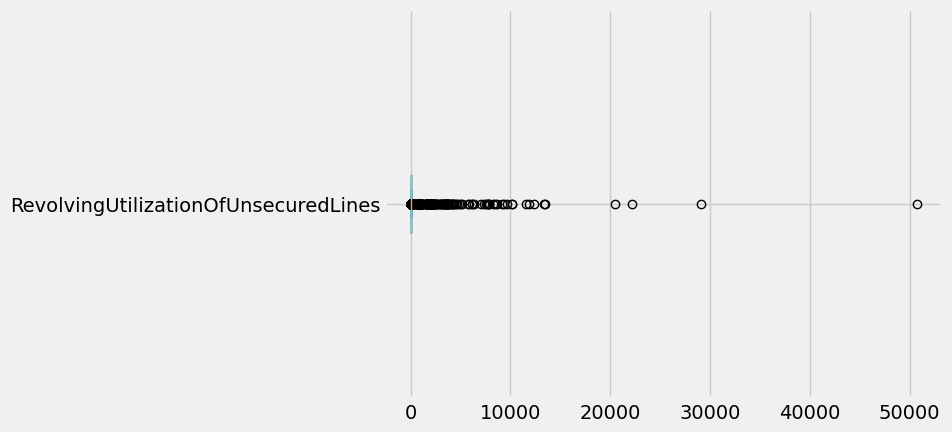

In [18]:
#check outlier for RevolvingUtilizationOfUnsecuredLines
training_set["RevolvingUtilizationOfUnsecuredLines"].plot.box(vert = False)
training_set.loc[training_set["RevolvingUtilizationOfUnsecuredLines"]>=
                 np.percentile(training_set["RevolvingUtilizationOfUnsecuredLines"], 98),
                 "RevolvingUtilizationOfUnsecuredLines"]=np.percentile(training_set["RevolvingUtilizationOfUnsecuredLines"], 98)

<Axes: >

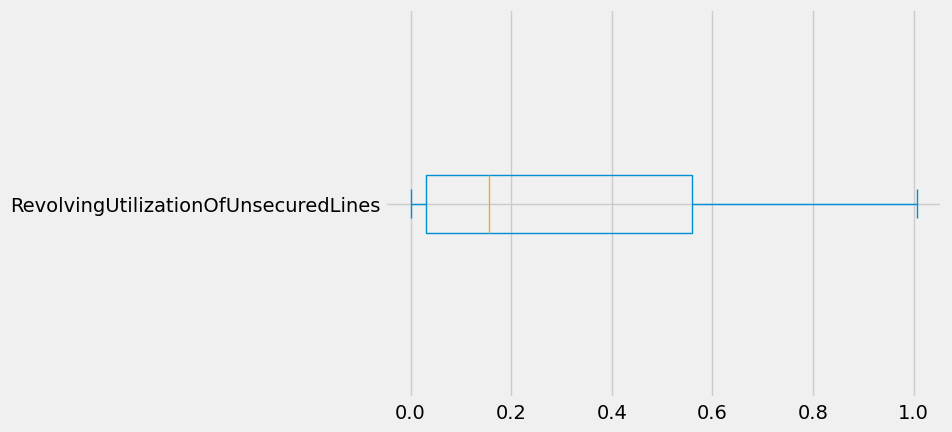

In [19]:
training_set["RevolvingUtilizationOfUnsecuredLines"].plot.box(vert = False)

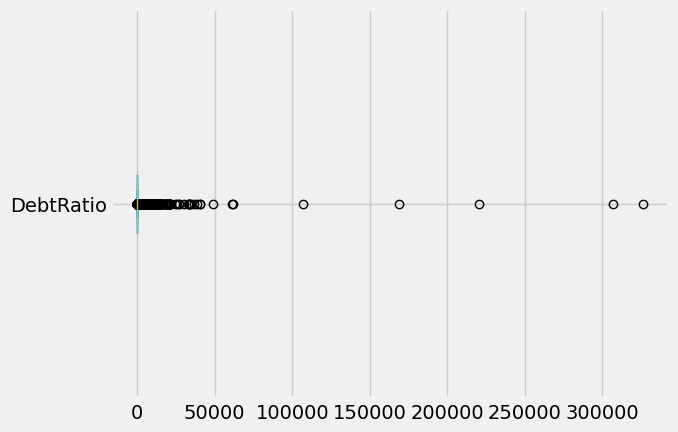

In [20]:
#check outlier for DebtRatio
training_set["DebtRatio"].plot.box(vert = False)
training_set.loc[training_set["DebtRatio"]>=
                 np.percentile(training_set["DebtRatio"], 70),
                 "DebtRatio"]=np.percentile(training_set["DebtRatio"], 70)

<Axes: >

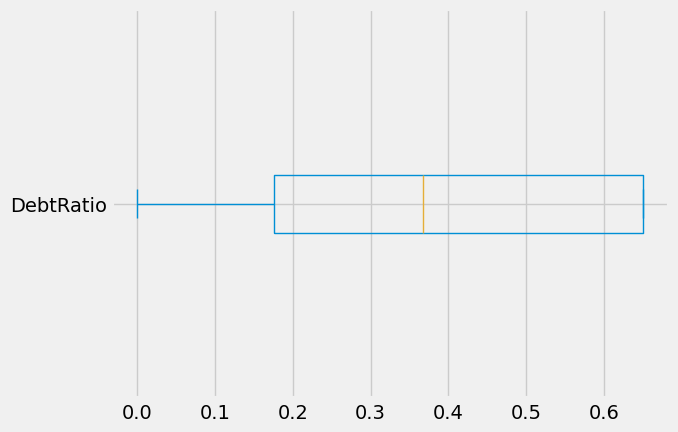

In [21]:
training_set["DebtRatio"].plot.box(vert = False)

In [22]:
training_set.describe()

,Unnamed: 0,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
count,112500.000000,112500.000000,112500.000000,112500.000000,112500.000000,1.125000e+05,112500.000000,112500.000000,112500.000000,112500.000000,112500.000000,112500.000000
mean,74961.876676,0.319667,52.288302,0.247280,0.375898,6.423300e+03,8.461564,0.090427,1.018924,0.064533,0.738667,0.067120
std,43333.928533,0.349542,14.766866,0.701417,0.232568,1.398983e+04,5.145291,0.486195,1.130766,0.329115,1.109378,0.250231
min,2.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37449.750000,0.030106,41.000000,0.000000,0.175877,3.900000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,74889.500000,0.155192,52.000000,0.000000,0.367473,5.415000e+03,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,112530.250000,0.559117,63.000000,0.000000,0.650405,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000,0.000000
max,150000.000000,1.006108,109.000000,12.000000,0.650405,3.008750e+06,58.000000,17.000000,54.000000,11.000000,13.000000,1.000000


In [23]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112500 entries, 92988 to 121958
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            112500 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  112500 non-null  float64
 2   age                                   112500 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  112500 non-null  int64  
 4   DebtRatio                             112500 non-null  float64
 5   MonthlyIncome                         112500 non-null  int64  
 6   NumberOfOpenCreditLinesAndLoans       112500 non-null  int64  
 7   NumberOfTimes90DaysLate               112500 non-null  int64  
 8   NumberRealEstateLoansOrLines          112500 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  112500 non-null  int64  
 10  NumberOfDependents                    112500 non-null  int64  
 11  S

# Feature Engineering

<Axes: >

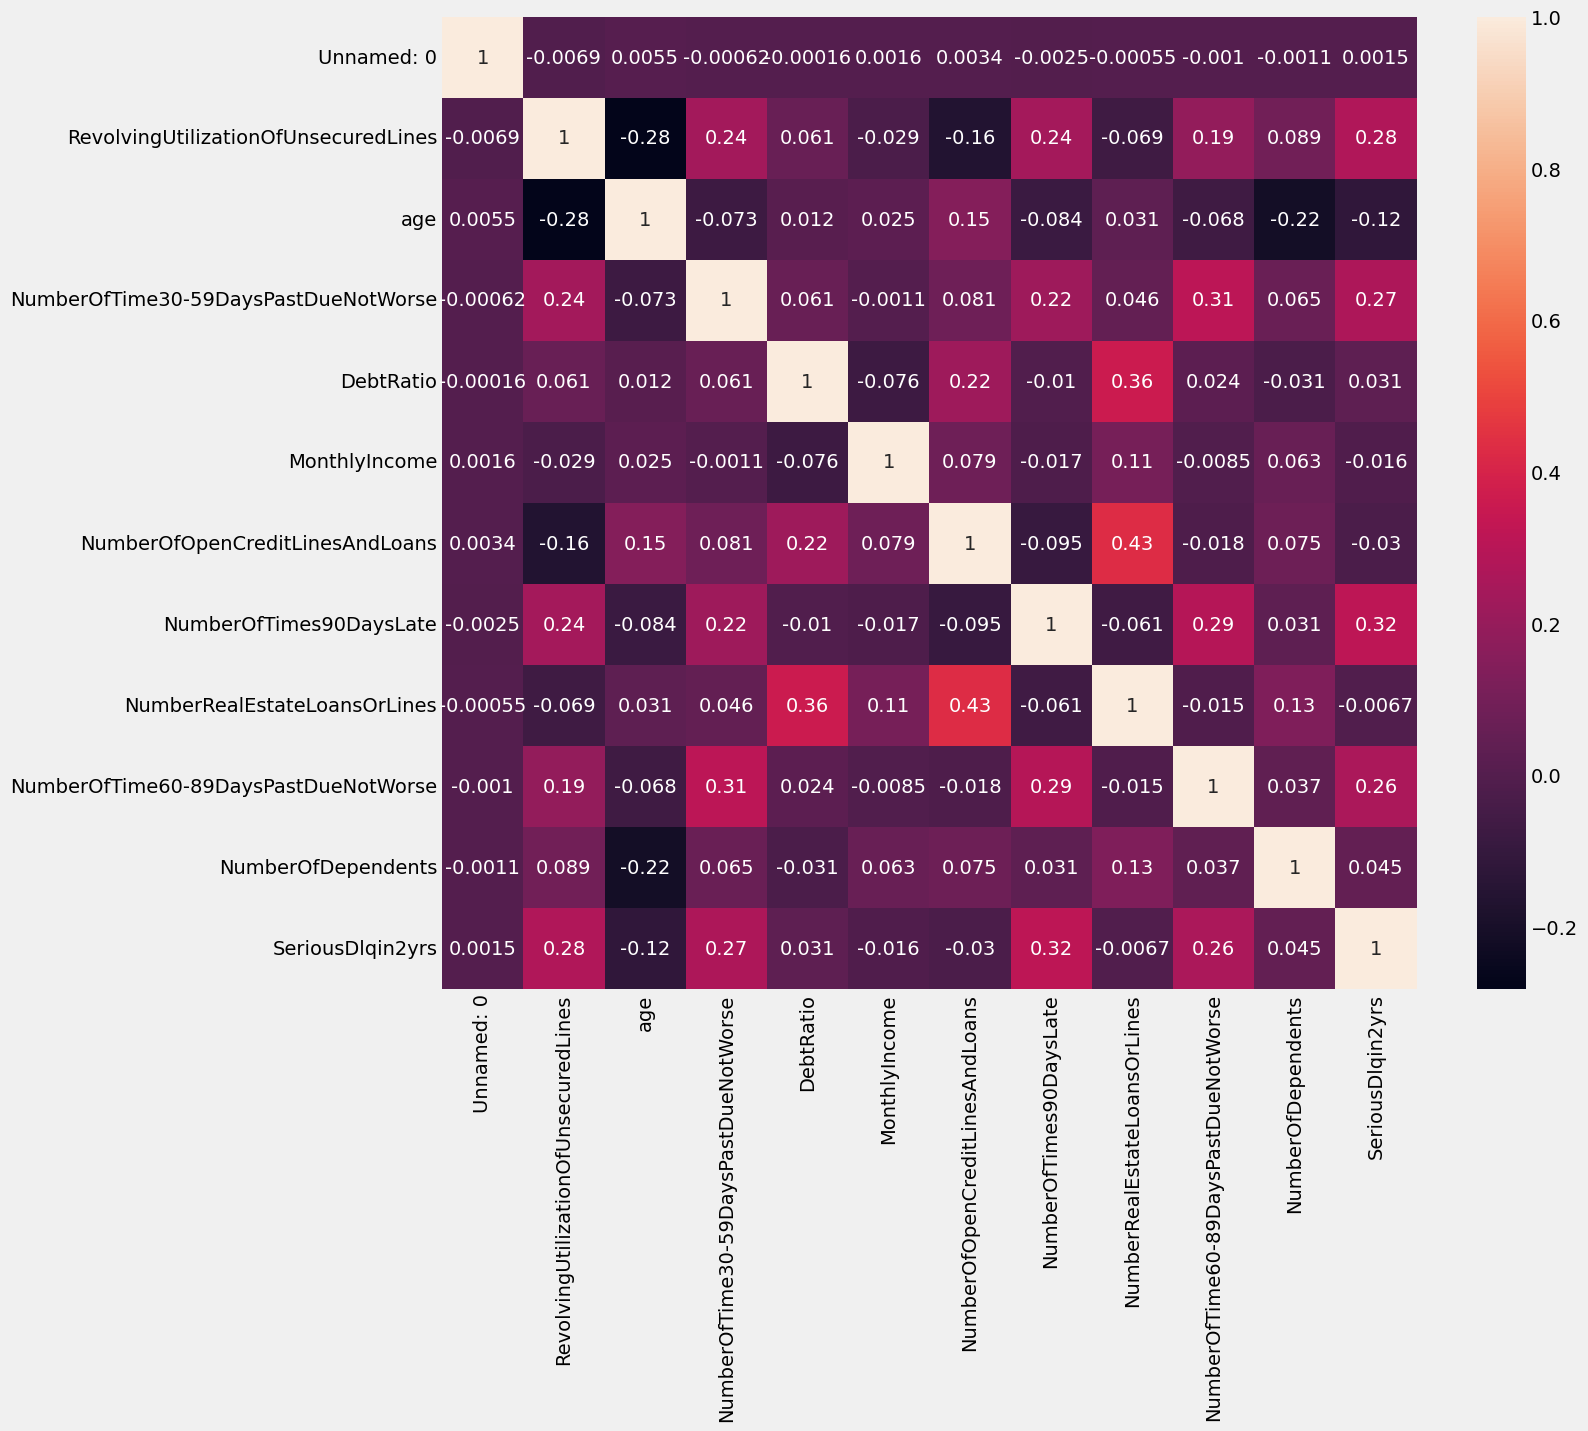

In [24]:
corr = training_set.corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr, annot=True, fmt=".2g")

In [25]:
 #create feature CombinedDefaulted
training_set["CombinedDefaulted"] = (training_set["NumberOfTimes90DaysLate"] + training_set["NumberOfTime60-89DaysPastDueNotWorse"])\
                                        + training_set["NumberOfTime30-59DaysPastDueNotWorse"]
training_set.loc[(training_set["CombinedDefaulted"] >= 1), "CombinedDefaulted"] = 1
training_set.CombinedDefaulted.value_counts()

CombinedDefaulted
0    89834
1    22666
Name: count, dtype: int64

In [26]:
#create feature CombinedLoans
training_set["CombinedLoans"] = training_set["NumberOfOpenCreditLinesAndLoans"] + \
                                        training_set["NumberRealEstateLoansOrLines"]
training_set.loc[(training_set["CombinedLoans"] <= 5), "CombinedLoans"] = 0
training_set.loc[(training_set["CombinedLoans"] > 5), "CombinedLoans"] = 1
training_set.CombinedLoans.value_counts()

CombinedLoans
1    83632
0    28868
Name: count, dtype: int64

In [27]:
# Create feature WithDependents
training_set["WithDependents"] = training_set["NumberOfDependents"]
training_set.loc[(training_set["WithDependents"] >= 1), "WithDependents"] = 1
training_set.WithDependents.value_counts()

WithDependents
0    68175
1    44325
Name: count, dtype: int64

In [28]:
#Create feature MonthlyDebtPayments
training_set["MonthlyDebtPayments"] = training_set["DebtRatio"] * training_set["MonthlyIncome"]
training_set["MonthlyDebtPayments"] = np.absolute(training_set["MonthlyDebtPayments"])
training_set["MonthlyDebtPayments"] = training_set["MonthlyDebtPayments"].astype('int64')

In [29]:
#change type of age and MonthlyIncome
training_set["age"] = training_set["age"].astype('int64')
training_set["MonthlyIncome"] = training_set["MonthlyIncome"].astype('int64')

<Axes: >

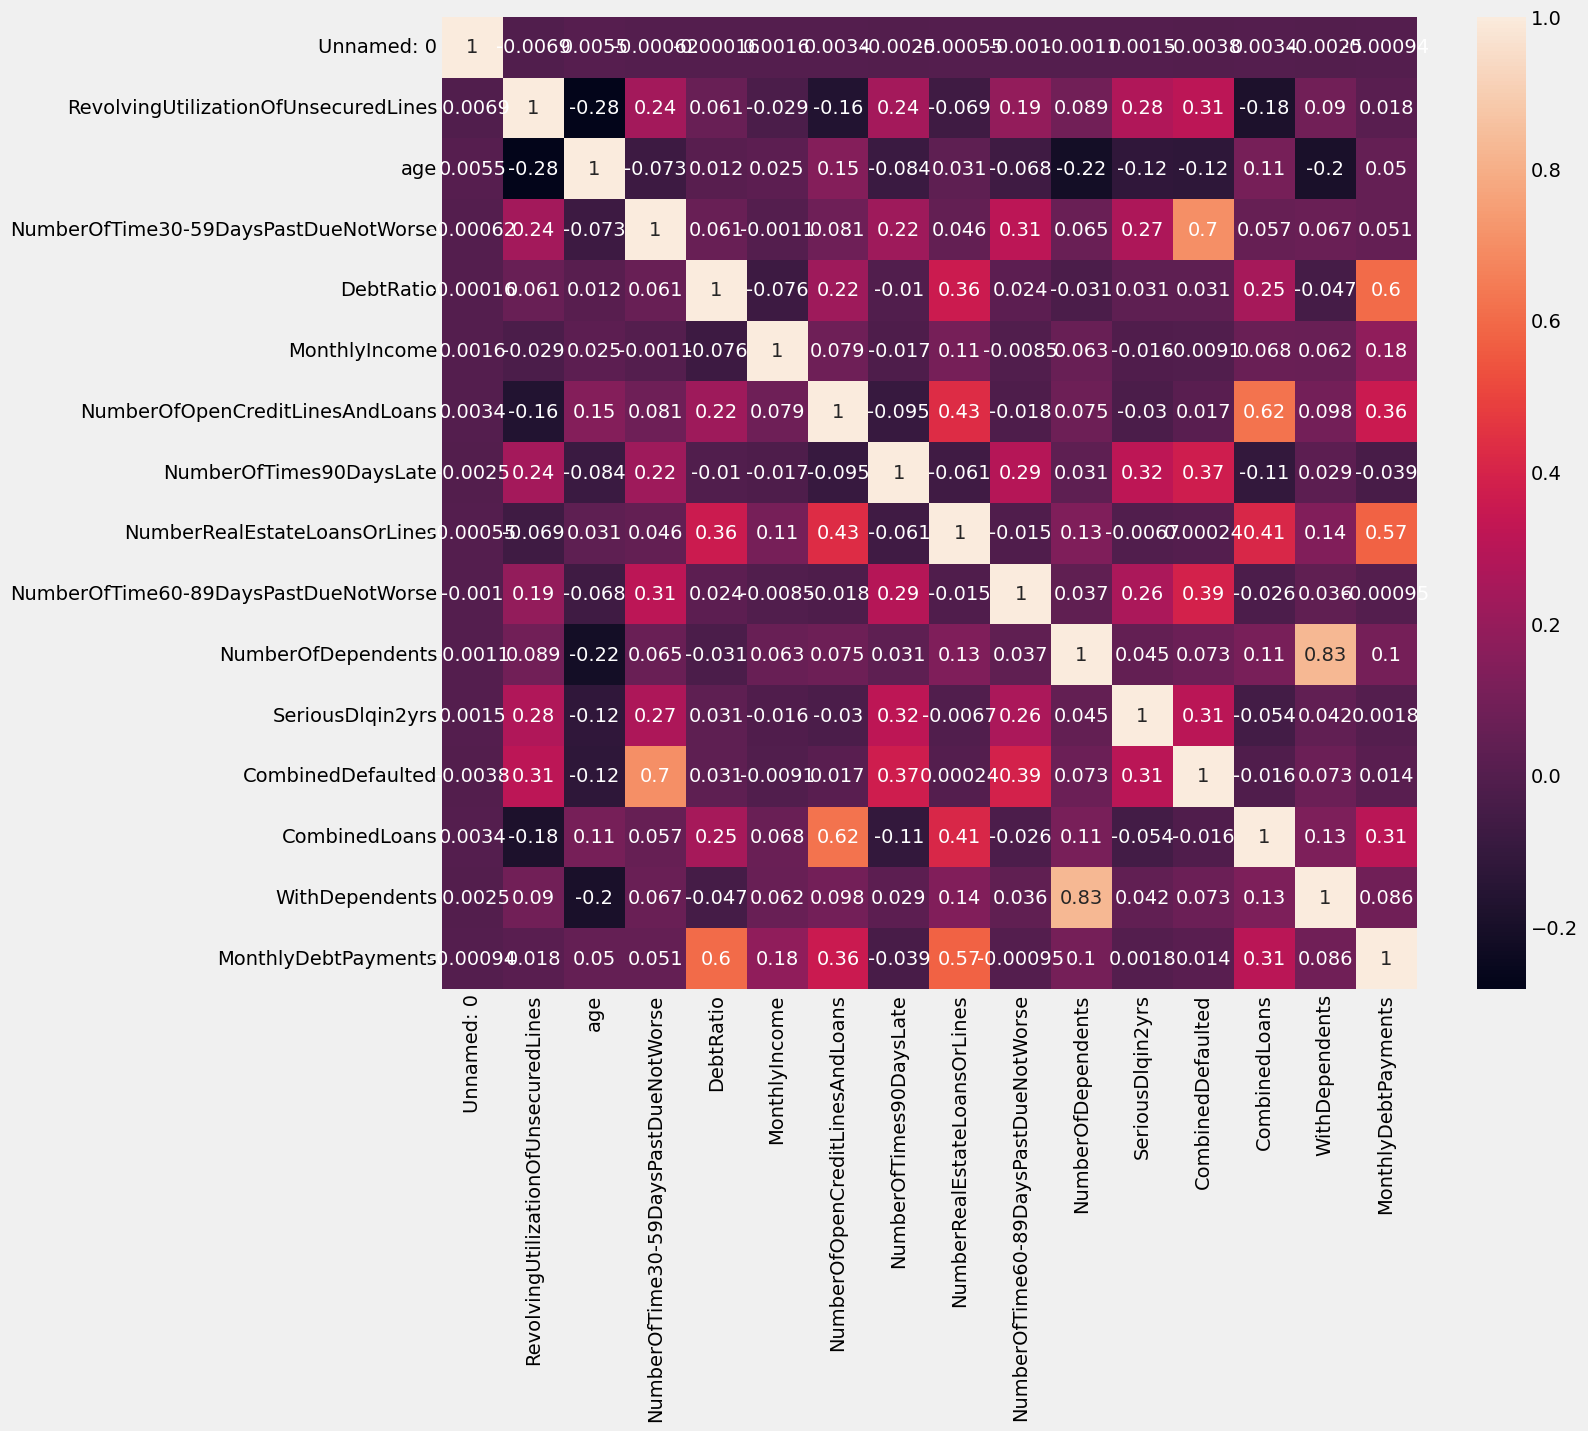

In [30]:
#check correlation again
corr = training_set.corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr, annot=True, fmt=".2g")

In [31]:
training_set.drop(["Unnamed: 0","NumberOfOpenCreditLinesAndLoans","NumberRealEstateLoansOrLines",
                 "NumberOfTime30-59DaysPastDueNotWorse","NumberOfTime60-89DaysPastDueNotWorse",\
                 "WithDependents", "MonthlyDebtPayments"], axis=1, inplace=True)

In [32]:
training_set.columns

Index(['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio',
       'MonthlyIncome', 'NumberOfTimes90DaysLate', 'NumberOfDependents',
       'SeriousDlqin2yrs', 'CombinedDefaulted', 'CombinedLoans'],
      dtype='object')

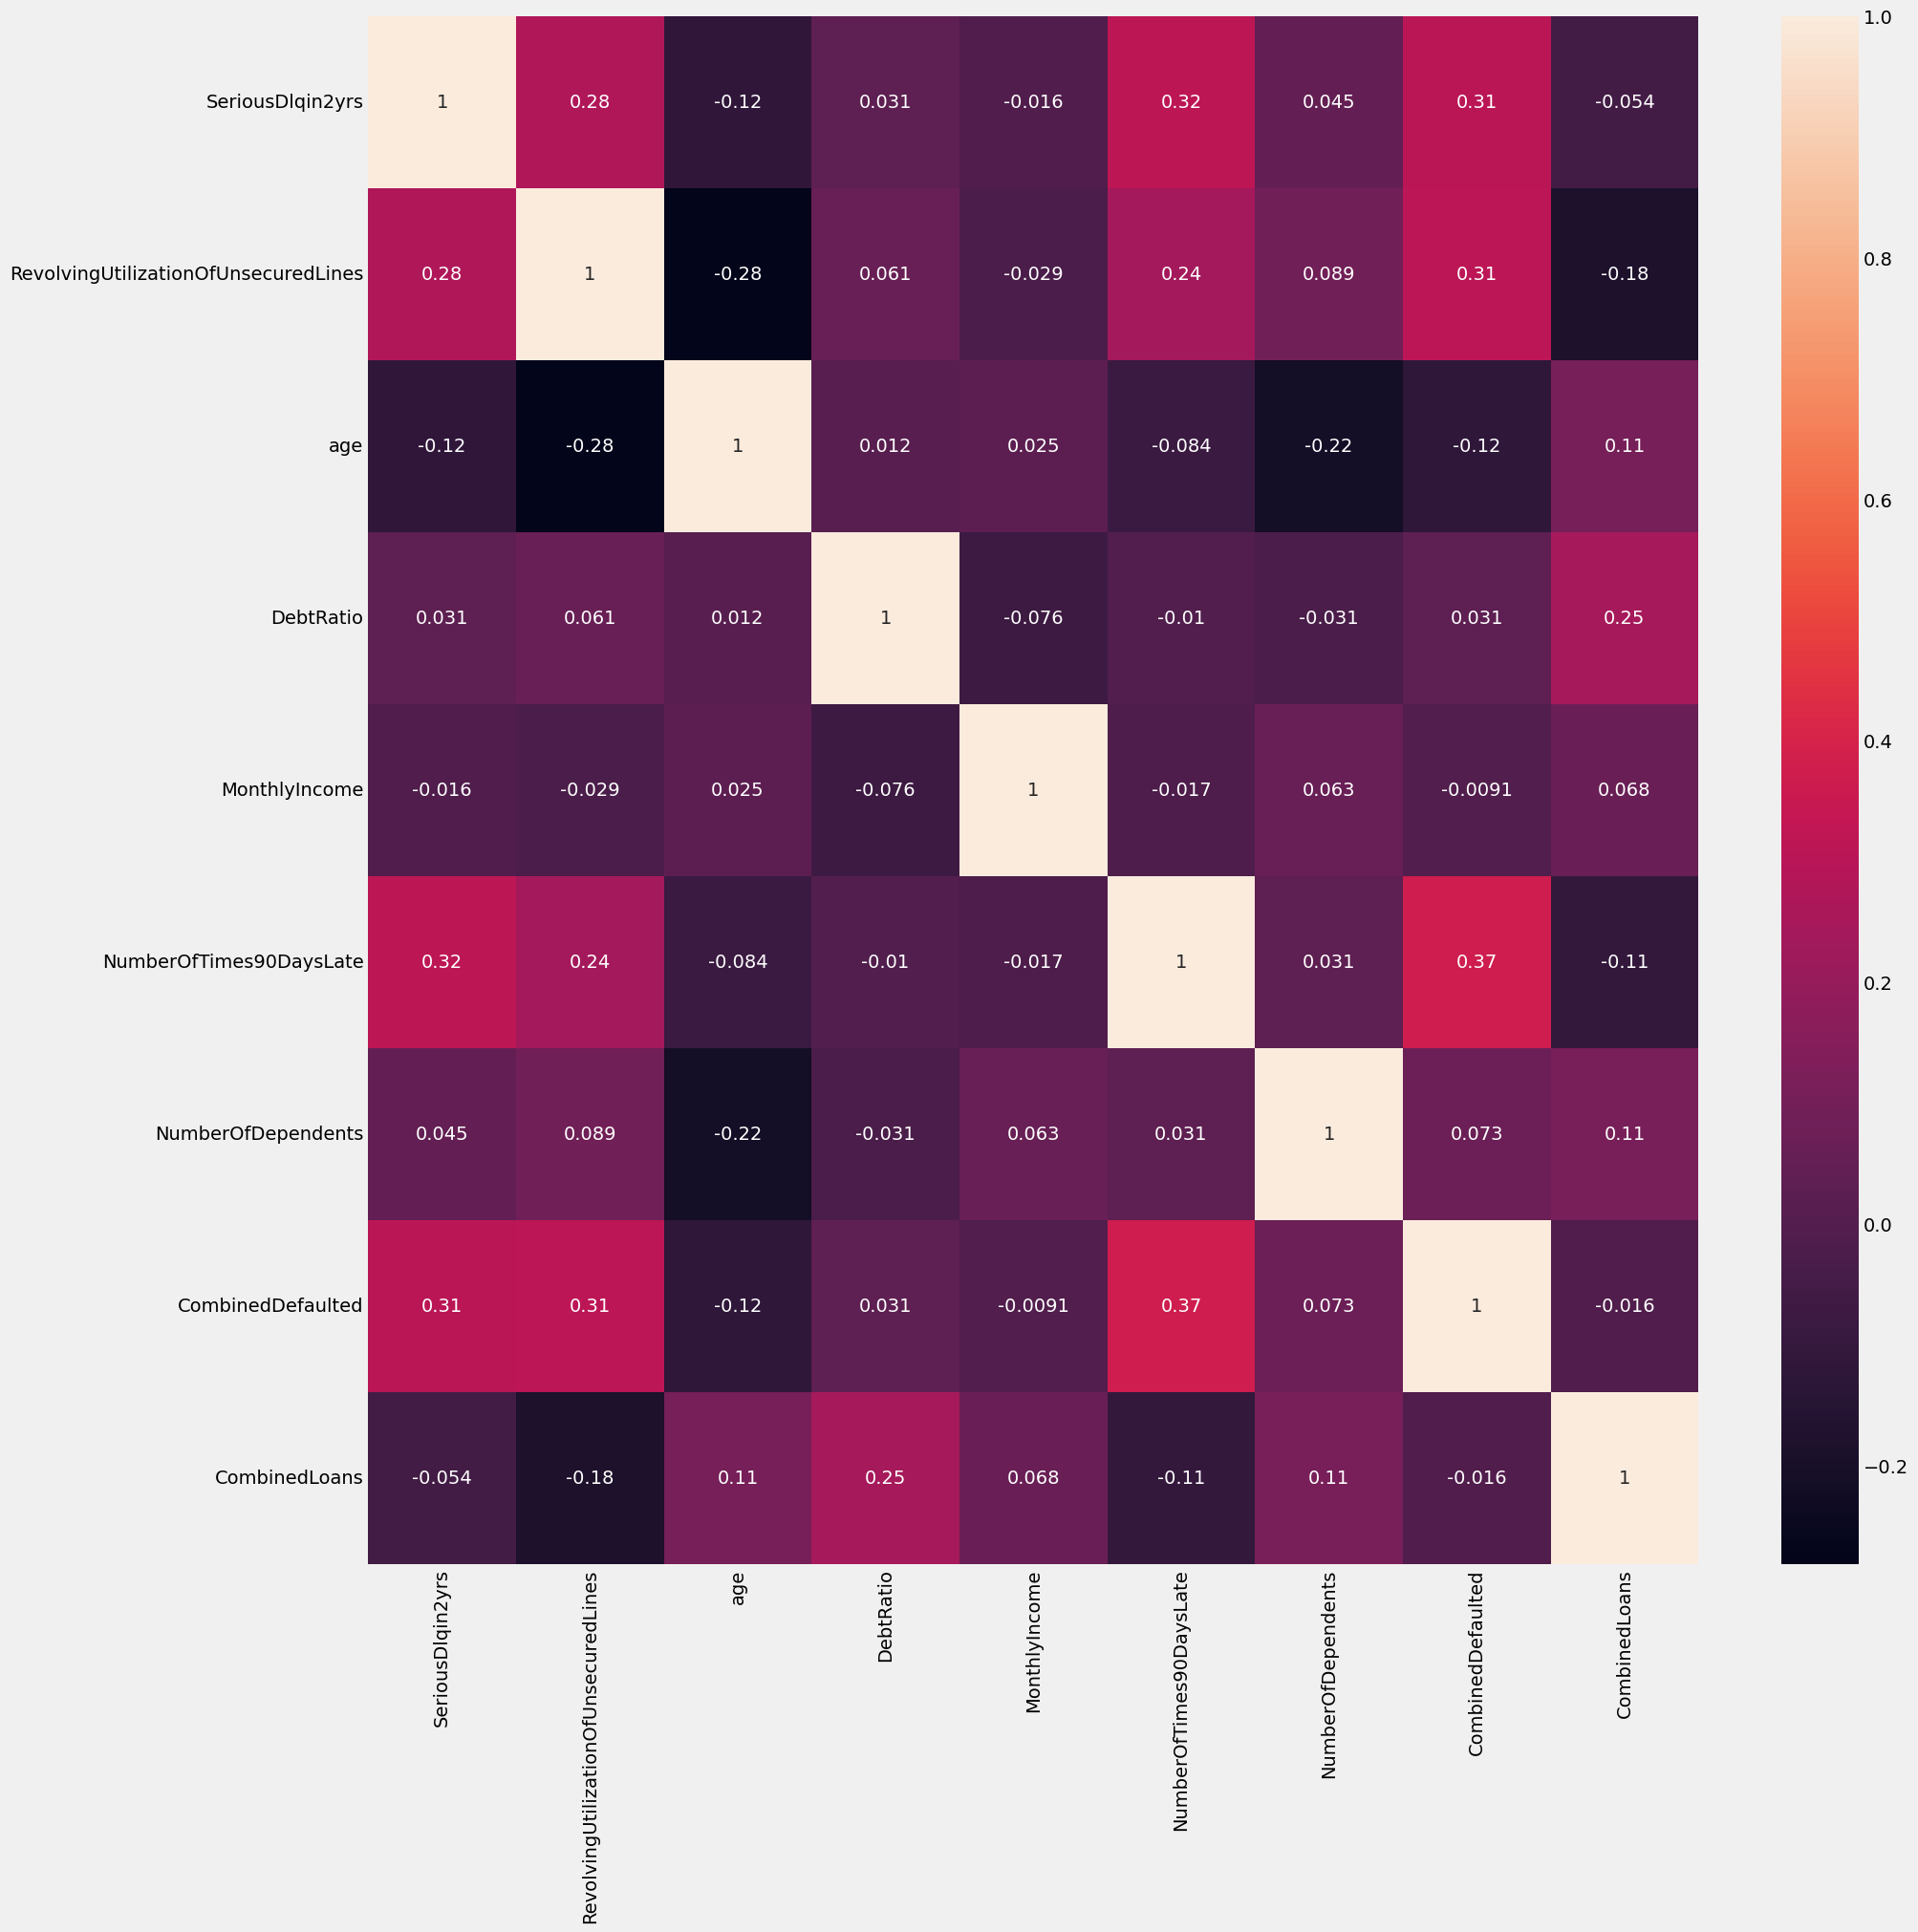

In [33]:
temp = pd.concat([training_set['SeriousDlqin2yrs'], training_set.drop('SeriousDlqin2yrs', axis=1)], axis=1)
corr = temp.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, fmt=".2g")
plt.savefig('correlation_heatmap.png', format='png')
plt.show()

In [34]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
training_set.groupby('SeriousDlqin2yrs').agg(['min', 'max', 'mean', 'std']).T

SeriousDlqin2yrs                                   0         1
RevolvingUtilizationOfUnsecuredLines min        0.00      0.00
                                     max        1.01      1.01
                                     mean       0.29      0.68
                                     std        0.33      0.35
age                                  min       21.00     21.00
                                     max      109.00    101.00
                                     mean      52.75     45.87
                                     std       14.79     12.88
DebtRatio                            min        0.00      0.00
                                     max        0.65      0.65
                                     mean       0.37      0.40
                                     std        0.23      0.23
MonthlyIncome                        min        0.00      0.00
                                     max  3008750.00 250000.00
                                     mean    6482.38   5602.19
                                     std    14397.35   5849.46
NumberOfTimes90DaysLate              min        0.00      0.00
                                     max       15.00     17.00
                                     mean       0.05      0.66
                                     std        0.33      1.30
NumberOfDependents                   min        0.00      0.00
                                     max       13.00      8.00
                                     mean       0.73      0.93
                                     std        1.10      1.21
CombinedDefaulted                    min        0.00      0.00
                                     max        1.00      1.00
                                     mean       0.17      0.66
                                     std        0.37      0.47
CombinedLoans                        min        0.00      0.00
                                     max        1.00      1.00
                                     mean       0.75      0.66
                                     std        0.43      0.48

In [35]:
pd.crosstab(training_set['SeriousDlqin2yrs'], training_set['CombinedDefaulted'])

CombinedDefaulted,0,1
SeriousDlqin2yrs,,
0,87287,17662
1,2547,5004


In [36]:
pd.crosstab(training_set['SeriousDlqin2yrs'], training_set['CombinedLoans'])

CombinedLoans,0,1
SeriousDlqin2yrs,,
0,26263,78686
1,2605,4946


# Same Feature Construction to the Validation Set

In [37]:
def cleaned_dataset(dataset):
    #tackle missing values and outliers
    dataset.loc[dataset["age"] <= 18, "age"] = dataset.age.median()
    
    dataset.loc[dataset['NumberOfTime30-59DaysPastDueNotWorse'] > 20, 'NumberOfTime30-59DaysPastDueNotWorse']=dataset["NumberOfTime30-59DaysPastDueNotWorse"].median()
    dataset.loc[dataset['NumberOfTime60-89DaysPastDueNotWorse'] > 20, 'NumberOfTime60-89DaysPastDueNotWorse']=dataset["NumberOfTime60-89DaysPastDueNotWorse"].median()
    dataset.loc[dataset['NumberOfTimes90DaysLate'] > 20, 'NumberOfTimes90DaysLate']=dataset["NumberOfTimes90DaysLate"].median()

    age_working_impute = dataset.loc[(dataset["age"] >= 18) & (dataset["age"] < 60)].MonthlyIncome.median()
    age_senior_impute =  dataset.loc[(dataset["age"] >= 60)].MonthlyIncome.median()
    dataset["MonthlyIncome"] = np.absolute(dataset["MonthlyIncome"])
    dataset["MonthlyIncome"] = dataset["MonthlyIncome"].fillna(99999)
    dataset["MonthlyIncome"] = dataset["MonthlyIncome"].astype('int64')
    dataset.loc[((dataset["age"] >= 18) & (dataset["age"] < 60)) & (dataset["MonthlyIncome"] == 99999),\
                   "MonthlyIncome"] = age_working_impute
    dataset.loc[(dataset["age"] >= 60) & (dataset["MonthlyIncome"] == 99999), "MonthlyIncome"] = age_senior_impute
    
    dataset["NumberOfDependents"] = np.absolute(dataset["NumberOfDependents"])
    dataset["NumberOfDependents"] = dataset["NumberOfDependents"].fillna(0)
    dataset["NumberOfDependents"] = dataset["NumberOfDependents"].astype('int64')
    
    dataset.loc[dataset["RevolvingUtilizationOfUnsecuredLines"]>=
                 np.percentile(dataset["RevolvingUtilizationOfUnsecuredLines"], 98),
                 "RevolvingUtilizationOfUnsecuredLines"]=np.percentile(dataset["RevolvingUtilizationOfUnsecuredLines"], 98)

    dataset.loc[dataset["DebtRatio"]>=
                 np.percentile(dataset["DebtRatio"], 70),
                 "DebtRatio"]=np.percentile(dataset["DebtRatio"], 70)
    
    #create new features
    dataset["CombinedDefaulted"] = (dataset["NumberOfTimes90DaysLate"] + dataset["NumberOfTime60-89DaysPastDueNotWorse"])\
                                            + dataset["NumberOfTime30-59DaysPastDueNotWorse"]

    dataset.loc[(dataset["CombinedDefaulted"] >= 1), "CombinedDefaulted"] = 1

    dataset["CombinedLoans"] = dataset["NumberOfOpenCreditLinesAndLoans"] + \
                                            dataset["NumberRealEstateLoansOrLines"]
    dataset.loc[(dataset["CombinedLoans"] <= 5), "CombinedLoans"] = 0
    dataset.loc[(dataset["CombinedLoans"] > 5), "CombinedLoans"] = 1

    dataset.drop(["Unnamed: 0","NumberOfOpenCreditLinesAndLoans","NumberRealEstateLoansOrLines",
                 "NumberOfTime30-59DaysPastDueNotWorse","NumberOfTime60-89DaysPastDueNotWorse"], axis=1, inplace=True)

cleaned_dataset(validation_set)

In [38]:
validation_set.columns

Index(['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio',
       'MonthlyIncome', 'NumberOfTimes90DaysLate', 'NumberOfDependents',
       'SeriousDlqin2yrs', 'CombinedDefaulted', 'CombinedLoans'],
      dtype='object')

In [39]:
validation_set.describe()

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfTimes90DaysLate,NumberOfDependents,SeriousDlqin2yrs,CombinedDefaulted,CombinedLoans
count,37500.00,37500.00,37500.00,37500.00,37500.00,37500.00,37500.00,37500.00,37500.00
mean,0.32,52.32,0.37,6380.03,0.09,0.73,0.07,0.20,0.74
std,0.35,14.78,0.23,8806.58,0.48,1.10,0.25,0.40,0.44
min,0.00,21.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.03,41.00,0.17,3918.00,0.00,0.00,0.00,0.00,0.00
50%,0.15,52.00,0.36,5417.00,0.00,0.00,0.00,0.00,1.00
75%,0.56,63.00,0.64,7345.25,0.00,1.00,0.00,0.00,1.00
max,1.01,102.00,0.64,835040.00,14.00,20.00,1.00,1.00,1.00


# Standardization

In [40]:
X_train = training_set.drop("SeriousDlqin2yrs", axis=1).copy()
y_train = pd.DataFrame(training_set.SeriousDlqin2yrs,index=training_set.index)

X_val = validation_set.drop("SeriousDlqin2yrs", axis=1).copy()
y_val = pd.DataFrame(validation_set.SeriousDlqin2yrs,index=validation_set.index)

scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_val =  pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)


# Resampling


In [41]:
#adjust training set sample ratio
training_set = pd.concat([X_train, y_train], axis=1)
training_set_0 = training_set[training_set['SeriousDlqin2yrs'] == 0]
training_set_1 = training_set[training_set['SeriousDlqin2yrs'] == 1]
training_set_0 = training_set_0.sample(n=len(training_set_1)*1, replace=True, random_state=42)
training_set = pd.concat([training_set_0, training_set_1], axis=0)
X_train_final=training_set.drop("SeriousDlqin2yrs", axis=1).copy()
y_train_final =training_set["SeriousDlqin2yrs"]
print("Resampled dataset shape {}".format(Counter(y_train_final)))


# adjust validation set sample ratio
validation_set = pd.concat([X_val, y_val], axis=1)
X_val_final=validation_set.drop("SeriousDlqin2yrs", axis=1).copy()
y_val_final =validation_set.SeriousDlqin2yrs
print("Resampled dataset shape {}".format(Counter(y_val_final)))

Resampled dataset shape Counter({0: 7551, 1: 7551})
Resampled dataset shape Counter({0: 35025, 1: 2475})


# RF Model Construction

In [42]:
X_train_final

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfTimes90DaysLate,NumberOfDependents,CombinedDefaulted,CombinedLoans
141960,-0.80,0.86,1.01,-0.11,-0.19,-0.67,-0.50,0.59
100866,-0.88,2.42,1.18,-0.08,-0.19,-0.67,-0.50,0.59
31575,-0.65,-0.76,-0.43,0.02,-0.19,-0.67,-0.50,0.59
40995,-0.56,0.05,0.24,-0.28,-0.19,-0.67,-0.50,0.59
57176,0.65,-0.29,-0.38,-0.19,-0.19,0.24,1.99,-1.70
...,...,...,...,...,...,...,...,...
65725,1.66,-0.09,-0.84,-0.12,8.04,1.14,1.99,-1.70
130523,-0.54,-0.36,0.26,0.03,-0.19,1.14,-0.50,0.59
149503,-0.91,0.05,-1.27,-0.28,-0.19,2.04,1.99,0.59
103355,1.61,0.93,-0.32,-0.24,-0.19,-0.67,1.99,0.59


In [43]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
forest = RandomForestClassifier(random_state=42,n_estimators=50, max_depth=5)
forest.fit(X_train_final, y_train_final)
forest_scores_proba = forest.predict_proba(X_train_final)
forest_scores = forest_scores_proba[:,1]

AUC Score 0.856366326250731


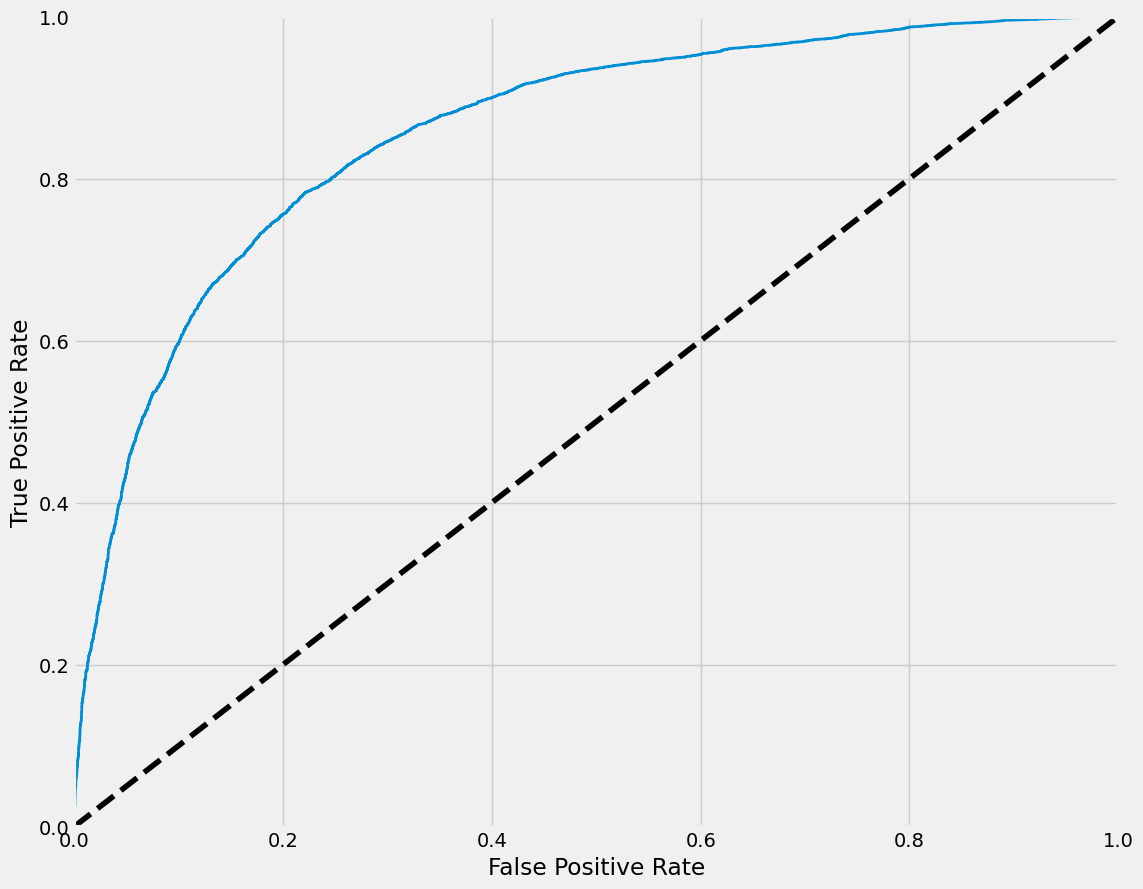

In [44]:
#performance on training set-AUC
fpr_logit, tpr_logit, thresh_logit = roc_curve(y_train_final, forest_scores)
plot_roc_curve(fpr_logit,tpr_logit)
print("AUC Score {}".format(roc_auc_score(y_train_final,forest_scores)))

AUC Score 0.8527675614099599


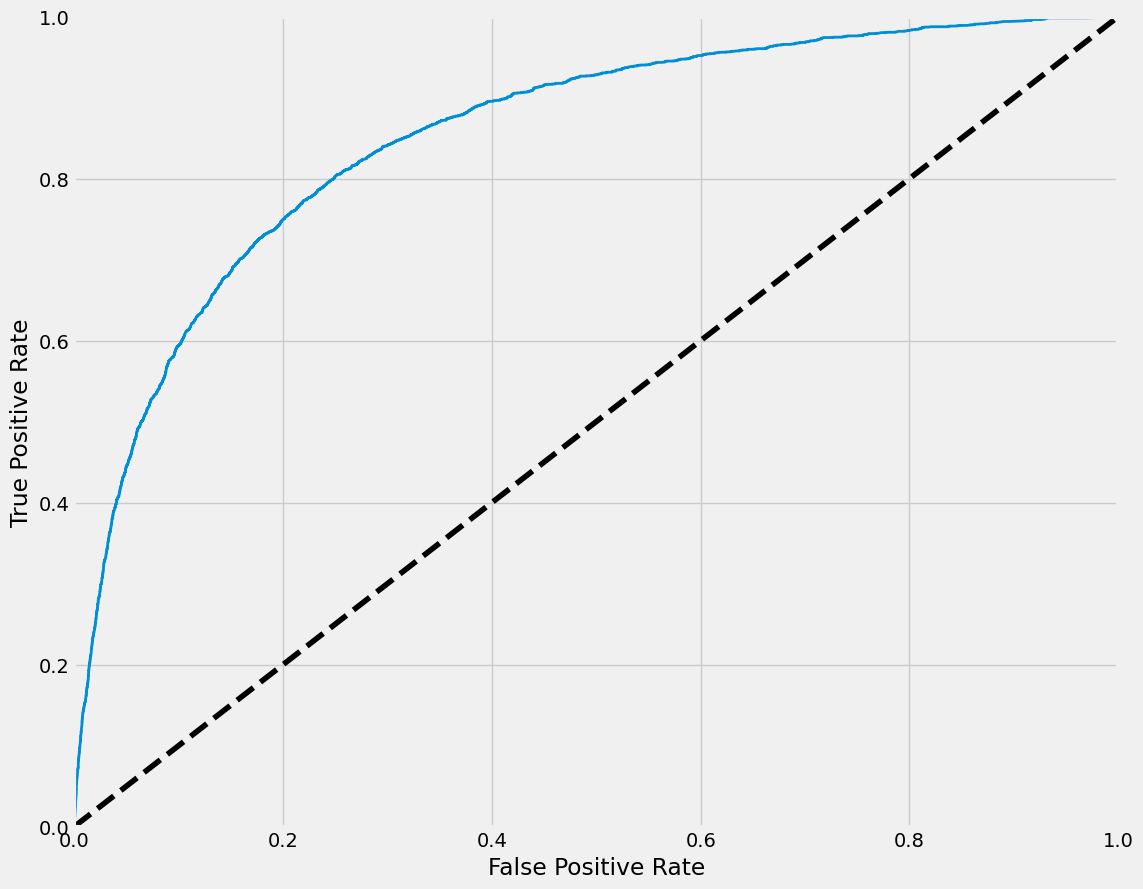

In [45]:
#performance on validation set
forest_scores_proba_val = forest.predict_proba(X_val_final)
forest_scores_val = forest_scores_proba_val[:,1]
fpr_logit_val, tpr_logit_val, thresh_logit_val = roc_curve(y_val_final, forest_scores_val)
plot_roc_curve(fpr_logit_val,tpr_logit_val)
print("AUC Score {}".format(roc_auc_score(y_val_final,forest_scores_val)))

In [46]:
#find the threshold that maximized profit on the validation set
pd.set_option('display.float_format', lambda x: '%.5f' % x)
ROCprofitinfo,importantlines,a = profit_threshold2(fpr_logit_val,tpr_logit_val, thresh_logit_val,y_val_final)

In [47]:
importantlines

,fpr,tpr,a,profit
1632,0.07329,0.52687,0.70023,1330.15000
1633,0.07343,0.52687,0.69979,1329.90000
1634,0.07343,0.52727,0.69976,1330.15000
1635,0.07398,0.52727,0.69741,1329.20000
1636,0.07398,0.52808,0.69721,1329.70000


In [48]:
#performance on validtaion set - accuracy with the threshold that maximizes profit
#logit_scores is the estimated probability of violation
predicted_labels = np.where(forest_scores_val>=a, 1, 0)
accuracy = np.mean(predicted_labels == y_val_final)
print("Accuracy:", accuracy)
pd.crosstab(predicted_labels,y_val_final)

Accuracy: 0.9002133333333333


SeriousDlqin2yrs,0,1
row_0,,
0,32453,1170
1,2572,1305


Text(0, 0.5, 'profit')

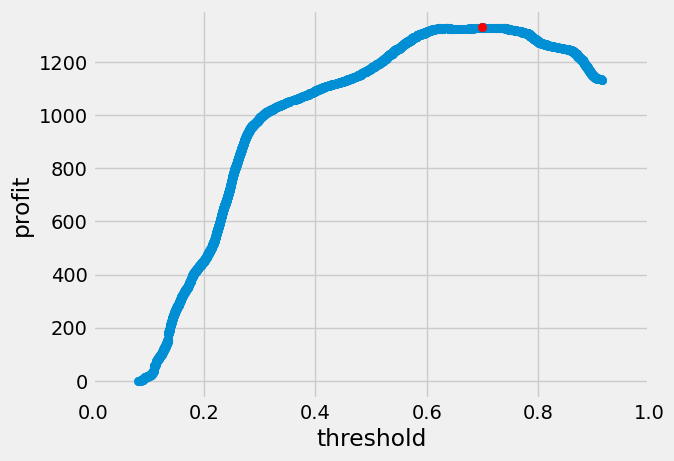

In [49]:
plt.scatter(ROCprofitinfo["a"], ROCprofitinfo["profit"])
plt.scatter(a, ROCprofitinfo.loc[ROCprofitinfo["a"] == a, "profit"], color='red', label='Max')
plt.xlim(0, 1)
plt.xlabel("threshold")
plt.ylabel("profit")

In [50]:
#Add a tangent line to the ROC curve
def plot_roc_curve_max(fpr, tpr, table,label=None):
    plt.figure(figsize=(12,10))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive rate")
    fpr_max = table.loc[table["a"] == a, "fpr"]
    tpr_max = table.loc[table["a"] == a, "tpr"]
    fpr_max = fpr_max.iloc[0]
    tpr_max = tpr_max.iloc[0]
    print(fpr_max)
    slope = 35025*0.05/(2475*0.25)
    fpr_line = np.arange(0, 1.0, 0.01)
    tpr_line = tpr_max + slope * (fpr_line - fpr_max)
    plt.plot(fpr_line, tpr_line, linestyle='-', color='blue', linewidth=2)
    plt.scatter(fpr_max, tpr_max, color='red')

0.0734332619557459


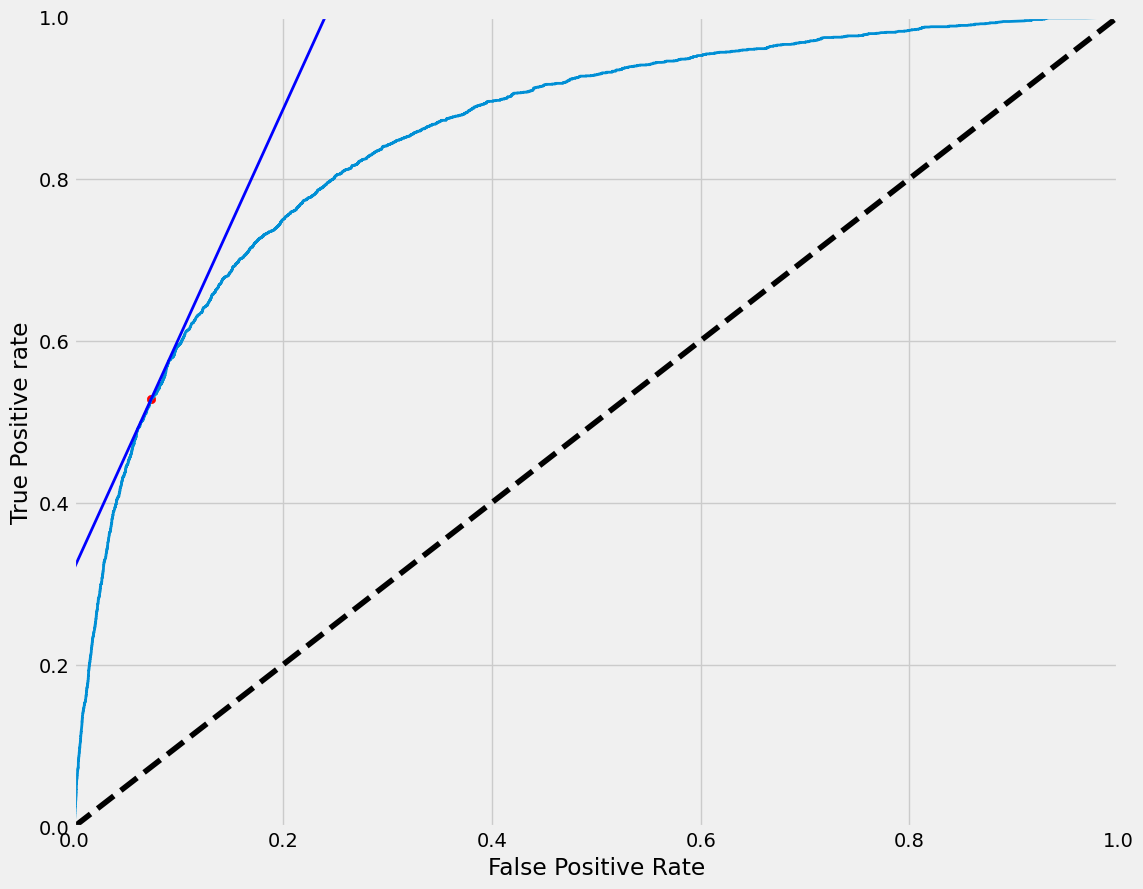

In [51]:
plot_roc_curve_max(fpr_logit_val,tpr_logit_val,ROCprofitinfo,label=None)

In [52]:
#calculate slope of ROC curve
ROCprofitinfo = ROCprofitinfo.iloc[::20]
ROCprofitinfo['fpr_back'] = ROCprofitinfo['fpr'].shift(1)
ROCprofitinfo['tpr_back'] = ROCprofitinfo['tpr'].shift(1)
ROCprofitinfo['fpr_forward'] = ROCprofitinfo['fpr'].shift(-1)
ROCprofitinfo['tpr_forward'] = ROCprofitinfo['tpr'].shift(-1)
ROCprofitinfo['slope'] = (ROCprofitinfo['tpr_forward']-ROCprofitinfo['tpr_back'])/(ROCprofitinfo['fpr_forward']-ROCprofitinfo['fpr_back'])
#selected_rows[(selected_rows['a'] > 0.4) & (selected_rows['a'] < 0.5)]
ROCprofitinfo

,fpr,tpr,a,profit,fpr_back,tpr_back,fpr_forward,tpr_forward,slope
0,0.00000,0.00000,1.91530,1132.50000,NaN,NaN,0.00040,0.01010,NaN
20,0.00040,0.01010,0.90650,1138.05000,0.00000,0.00000,0.00086,0.02343,27.35960
40,0.00086,0.02343,0.90093,1145.50000,0.00040,0.01010,0.00131,0.03152,23.43845
60,0.00131,0.03152,0.89859,1149.70000,0.00086,0.02343,0.00174,0.03960,18.26002
80,0.00174,0.03960,0.89625,1153.95000,0.00131,0.03152,0.00211,0.05333,27.29221
...,...,...,...,...,...,...,...,...,...
8820,0.98764,0.99919,0.10252,21.15000,0.98578,0.99879,0.98949,0.99919,0.10886
8840,0.98949,0.99919,0.09944,17.90000,0.98764,0.99919,0.99141,0.99919,0.00000
8860,0.99141,0.99919,0.09627,14.55000,0.98949,0.99919,0.99335,0.99960,0.10483
8880,0.99335,0.99960,0.09319,11.40000,0.99141,0.99919,0.99820,0.99960,0.05946


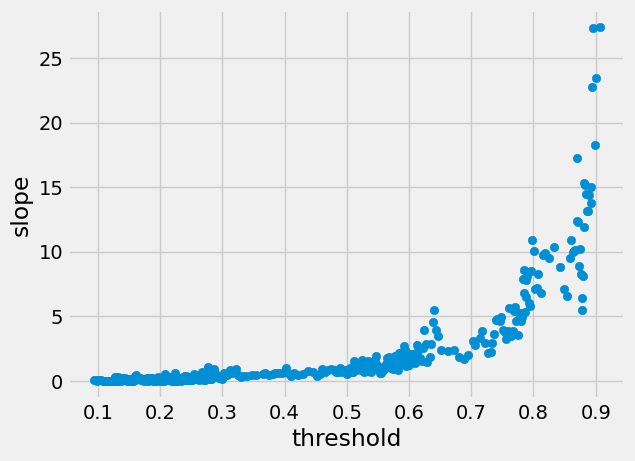

In [53]:
#Plot of threshold-profit
plt.scatter(ROCprofitinfo["a"], ROCprofitinfo["slope"])
plt.xlabel('threshold')  
plt.ylabel('slope') 
plt.show()

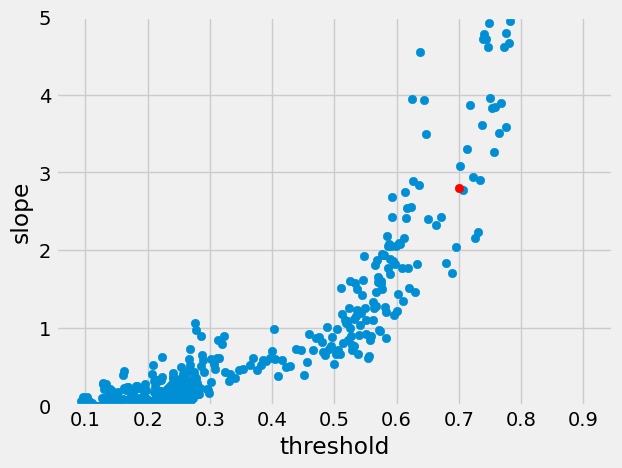

In [54]:
#enlarge specifc region of plot of threshold-profit
plt.scatter(ROCprofitinfo["a"], ROCprofitinfo["slope"])
plt.xlabel('threshold')  
plt.ylabel('slope') 
plt.scatter(a, 2.7919, color='red', label='Extra Point')
plt.ylim(0, 5)
plt.show()

In [55]:
AUC = []
profit = []
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
for k in range(30, 500):
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    forest = RandomForestClassifier(random_state=42,n_estimators=k, max_depth=5)
    forest.fit(X_train_final, y_train_final)
    forest_scores_proba_val = forest.predict_proba(X_val_final)
    forest_scores_val = forest_scores_proba_val[:,1]
    fpr_logit_val, tpr_logit_val, thresh_logit_val = roc_curve(y_val_final, forest_scores_val)
    AUC_temp=roc_auc_score(y_val_final,forest_scores_val)
    ROCprofitinfo,importantlines,a = profit_threshold2(fpr_logit_val,tpr_logit_val, thresh_logit_val,y_val_final)
    profit_temp=ROCprofitinfo.loc[ROCprofitinfo["a"] == a, "profit"]
    profit_temp=profit_temp.iloc[0]
    AUC.append(AUC_temp)
    profit.append(profit_temp)

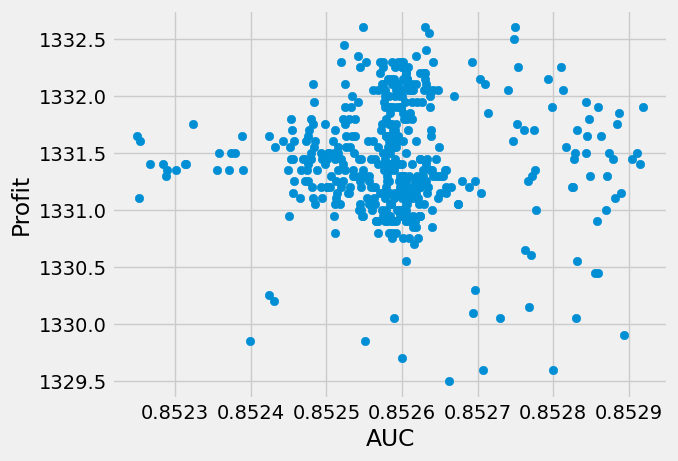

In [56]:
plt.scatter(AUC, profit)
plt.xlabel("AUC")
plt.ylabel("Profit")
plt.savefig("4to1scatter.png")

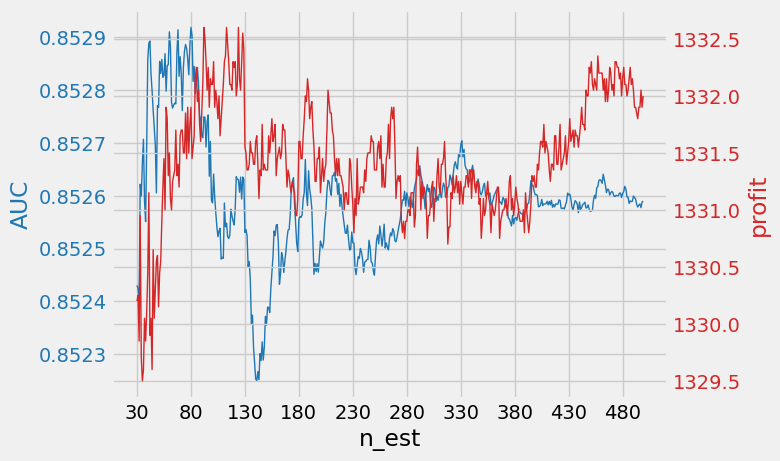

<Figure size 640x480 with 0 Axes>

In [57]:
K_values = list(range(30, 500))
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('n_est')
ax1.set_ylabel('AUC', color=color)
ax1.plot(K_values, AUC, color=color,linewidth=1)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('profit', color=color)
ax2.plot(K_values, profit, color=color,linewidth=1)
ax2.tick_params(axis='y', labelcolor=color)
plt.xticks(range(30, 500, 50))
plt.show()
plt.savefig("4to1linewidth11.png")

# KNN Model Construction

In [58]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=85)
knn_model.fit(X_train_final, y_train_final)
knn_scores_proba = knn_model.predict_proba(X_train_final)
knn_scores = knn_scores_proba[:, 1]

AUC Score 0.8557802440688446


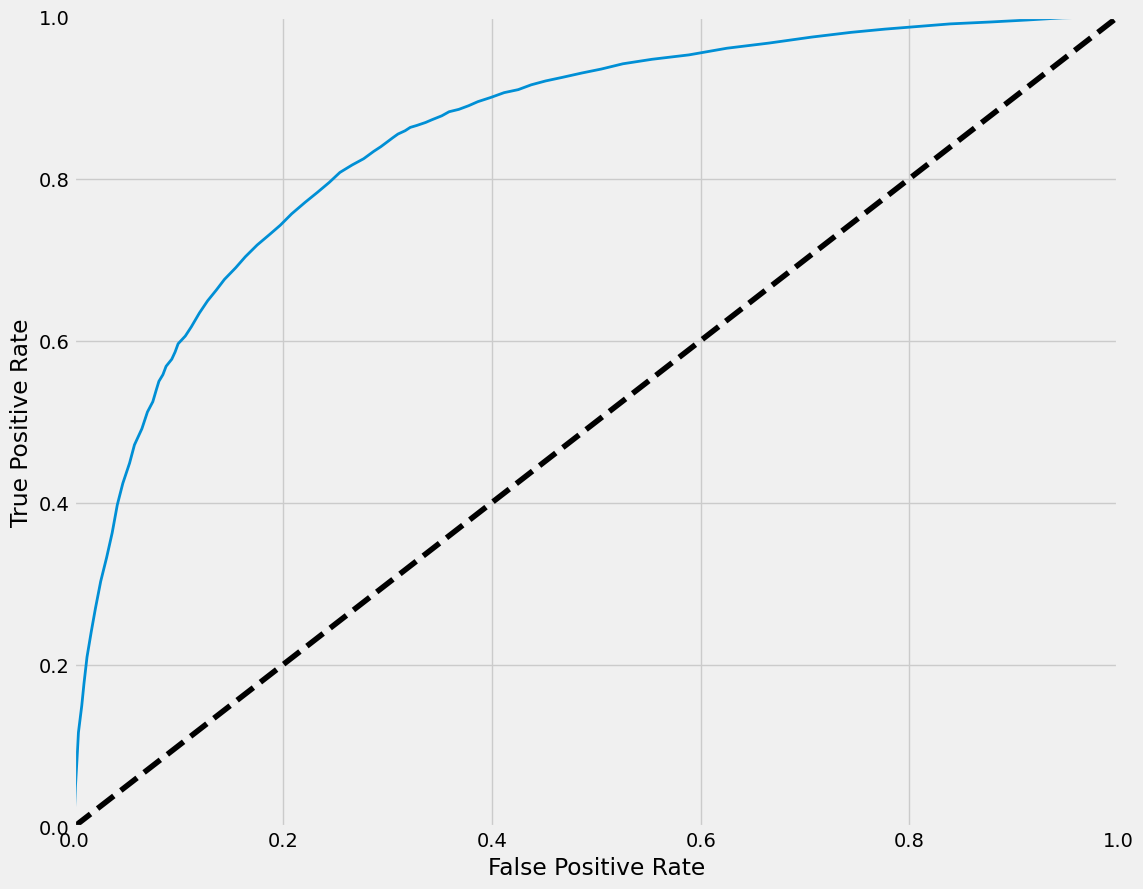

In [59]:
# performance on training set
fpr_logit, tpr_logit, thresh_logit = roc_curve(y_train_final, knn_scores)
plot_roc_curve(fpr_logit,tpr_logit)
print("AUC Score {}".format(roc_auc_score(y_train_final,knn_scores)))

AUC Score 0.8486494293397934


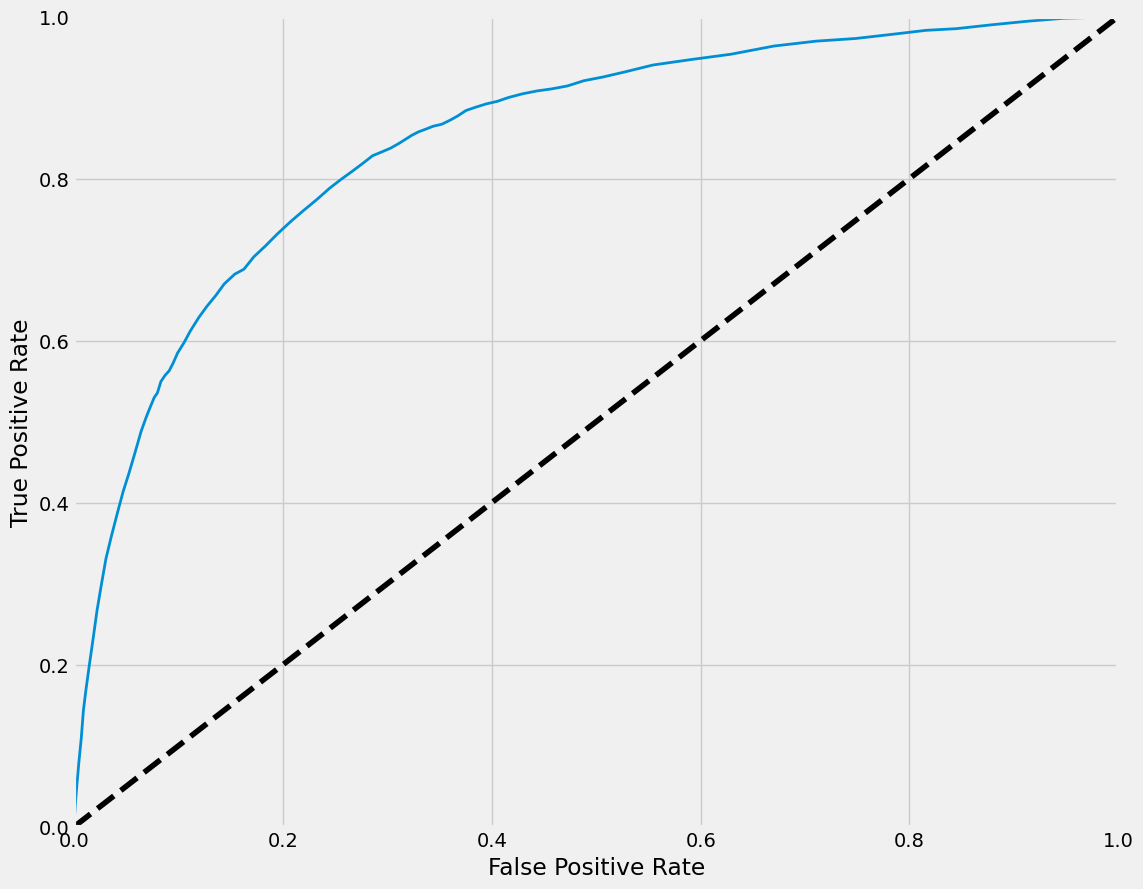

In [60]:
#performance on validation set
knn_scores_proba_val = knn_model.predict_proba(X_val_final)
knn_scores_val = knn_scores_proba_val[:,1]
fpr_logit_val, tpr_logit_val, thresh_logit_val = roc_curve(y_val_final, knn_scores_val)
plot_roc_curve(fpr_logit_val,tpr_logit_val)
print("AUC Score {}".format(roc_auc_score(y_val_final,knn_scores_val)))

In [61]:
#find the threshold that maximized profit on the validation set
pd.set_option('display.float_format', lambda x: '%.5f' % x)
ROCprofitinfo,importantlines,a = profit_threshold2(fpr_logit_val,tpr_logit_val, thresh_logit_val,y_val_final)

In [62]:
importantlines

,fpr,tpr,a,profit
22,0.07655,0.52970,0.75294,1326.20000
23,0.07960,0.53535,0.74118,1324.35000
24,0.08297,0.54949,0.72941,1327.20000
25,0.08700,0.55717,0.71765,1324.90000
26,0.09096,0.56283,0.70588,1321.45000


Text(0, 0.5, 'profit')

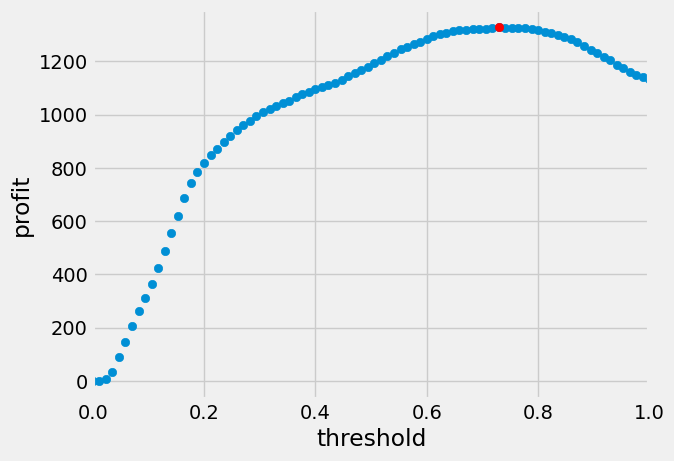

In [63]:
plt.scatter(ROCprofitinfo["a"], ROCprofitinfo["profit"])
plt.scatter(a, ROCprofitinfo.loc[ROCprofitinfo["a"] == a, "profit"], color='red', label='Max')
plt.xlim(0, 1)
plt.xlabel("threshold")
plt.ylabel("profit")

In [64]:
#performance on validtaion set - accuracy with the threshold that maximizes profit
#logit_scores is the estimated probability of violation
predicted_labels = np.where(knn_scores_val>=a, 1, 0)
accuracy = np.mean(predicted_labels == y_val_final)
print("Accuracy:", accuracy)
pd.crosstab(predicted_labels,y_val_final)

Accuracy: 0.8927733333333333


SeriousDlqin2yrs,0,1
row_0,,
0,32119,1115
1,2906,1360


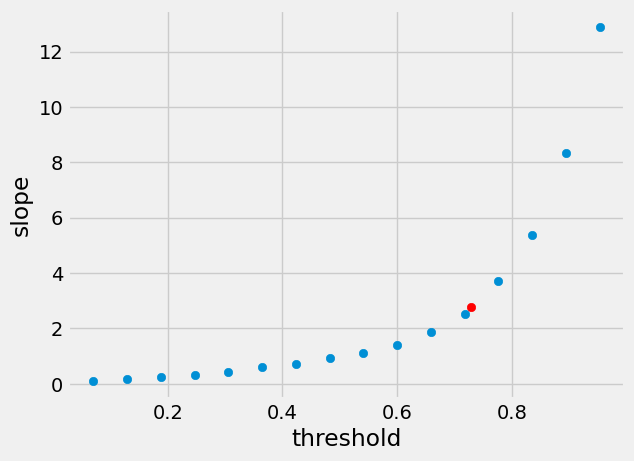

In [65]:
ROCprofitinfo = ROCprofitinfo.iloc[::5]
ROCprofitinfo['fpr_back'] = ROCprofitinfo['fpr'].shift(1)
ROCprofitinfo['tpr_back'] = ROCprofitinfo['tpr'].shift(1)
ROCprofitinfo['fpr_forward'] = ROCprofitinfo['fpr'].shift(-1)
ROCprofitinfo['tpr_forward'] = ROCprofitinfo['tpr'].shift(-1)
ROCprofitinfo['slope'] = (ROCprofitinfo['tpr_forward']-ROCprofitinfo['tpr_back'])/(ROCprofitinfo['fpr_forward']-ROCprofitinfo['fpr_back'])
plt.scatter(ROCprofitinfo["a"], ROCprofitinfo["slope"])
plt.xlabel('threshold')  
plt.ylabel('slope') 
plt.scatter(a, 2.7919, color='red', label='Extra Point')
plt.show()

In [66]:
AUC = []
profit = []
from sklearn.neighbors import KNeighborsClassifier
for k in range(1, 101):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_final, y_train_final)
    knn_scores_proba_val = knn_model.predict_proba(X_val_final)
    knn_scores_val = knn_scores_proba_val[:,1]
    fpr_logit_val, tpr_logit_val, thresh_logit_val = roc_curve(y_val_final, knn_scores_val)
    AUC_temp=roc_auc_score(y_val_final,knn_scores_val)
    ROCprofitinfo,importantlines,a = profit_threshold2(fpr_logit_val,tpr_logit_val, thresh_logit_val,y_val_final)
    profit_temp=ROCprofitinfo.loc[ROCprofitinfo["a"] == a, "profit"]
    profit_temp=profit_temp.iloc[0]
    AUC.append(AUC_temp)
    profit.append(profit_temp)

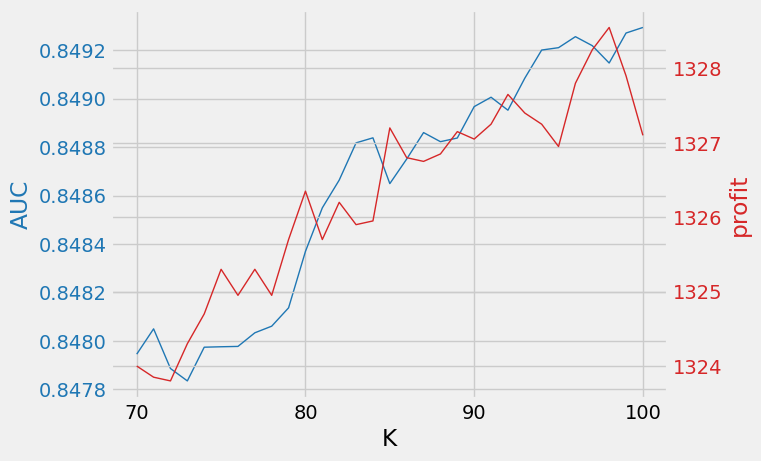

In [67]:
import matplotlib.pyplot as plt
K_values = list(range(70, 101))
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('K')
ax1.set_ylabel('AUC', color=color)
ax1.plot(K_values, AUC[69:], color=color,linewidth=1)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('profit', color=color)
ax2.plot(K_values, profit[69:], color=color,linewidth=1)
ax2.tick_params(axis='y', labelcolor=color)
plt.xticks(range(70, 101, 10))
plt.show()